# Team 21: APS360 Final Project Source Code


Attached is the code for Team 21's APS360 Final Project's source code. This is our project for bounding box pothole detection.

# Data Augmentation Functions

Utilize albumentations library for augmentations


In [ ]:
import random
import matplotlib.patches as patches
import math

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"


True
12.4
90300


In [ ]:
%pip install --user albumentations


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_custom_transforms(
    flip=False,
    rotate=False,
    color_jitter=False,
    brightness_contrast=False,
    blur=False,
    crop_resize=False,
    normalize=False
):
    transform_list = []

    # flips with 50% probability
    if flip:
        transform_list.append(A.HorizontalFlip(p=0.5))

    # rotates +-10 degrees with 30% prob
    if rotate:
        transform_list.append(A.Rotate(limit=10, p=0.5))

    if crop_resize:
        transform_list.extend([
            A.RandomCrop(width=384, height=384, p=0.3),
            A.Resize(512, 512)
        ])
    else:
        transform_list.append(A.Resize(512, 512))

    if color_jitter:
        transform_list.append(A.ColorJitter(
            brightness=0.05, contrast=0.05, saturation=0.05, hue=0.02, p=0.5))

    if brightness_contrast:
        transform_list.append(A.RandomBrightnessContrast(p=0.3))

    if blur:
        transform_list.append(A.OneOf([
            A.MotionBlur(blur_limit=3),
            A.MedianBlur(blur_limit=3),
            A.GaussianBlur(blur_limit=3)
        ], p=0.2))

    if normalize:
      transform_list.append(A.Normalize(
          mean=(0.485, 0.456, 0.406),
          std=(0.229, 0.224, 0.225)
      ))
    transform_list.append(ToTensorV2())

    return A.Compose(
        transform_list,
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Import Modules

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

## Import and mount dataset from Google Drive

In [ ]:
import os
import json
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from tqdm import tqdm

class PotholeDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):

      self.split = split
      self.transform = transform
      self.samples = []

      self.img_dir = os.path.join(root_dir, split, "img")
      self.json_dir = os.path.join(root_dir, split, "json")

      self.ignore_keywords = ["China_Drone", "China_MotorBike"]

      self.img_filenames = sorted(os.listdir(self.img_dir))
      total_files = len(self.img_filenames)
      print(f"[{split.upper()}] Total images: {total_files}")

      for fname in tqdm(self.img_filenames, desc=f"{split.upper()} loading"):
          if any(keyword in fname for keyword in self.ignore_keywords):
            print("Skipping invalid ones")
            continue

          img_path = os.path.join(self.img_dir, fname)
          json_path = os.path.join(self.json_dir, fname + ".json")

          if not os.path.exists(img_path):
              print(f"[SKIP] Missing image: {img_path}")
              continue

          if os.path.exists(json_path) and os.stat(json_path).st_size > 0:
              # Image with valid annotation
              self.samples.append(("with", fname))
          else:
              # Negative sample: no JSON or empty JSON
              self.samples.append(("without", fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      category, filename = self.samples[idx]
      img_path = os.path.join(self.img_dir, filename)
      json_path = os.path.join(self.json_dir, filename + ".json")

      image = cv2.imread(img_path)
      if image is None:
          # print(f"[SKIP] Corrupted image during loading: {img_path}")
          return torch.zeros(3, 512, 512), torch.zeros((0, 4)), torch.zeros((0,), dtype=torch.int64)

      boxes = []
      labels = []

      if os.path.exists(json_path) and os.stat(json_path).st_size > 0:
          with open(json_path, "r") as f:
              try:
                  data = json.load(f)
              except json.JSONDecodeError:
                  print(f"[SKIP] Malformed JSON: {json_path}")
                  data = {}

          objects = data.get("objects", [])
          # print(f"🔍 {filename} -> {len(objects)} objects")

          for obj in objects:
              class_title = obj.get("classTitle", "")
              # print(f"   classTitle: {class_title}")
              if class_title == "pothole":
                  points = obj.get("points", {}).get("exterior", [])
                  # print(f"   points: {points}")
                  if len(points) == 2:
                      (x1, y1), (x2, y2) = points
                      boxes.append([x1, y1, x2, y2])
          labels = [1] * len(boxes)

      # else:
      #     print(f"[NO JSON or EMPTY] {json_path}")

      boxes = np.array(boxes, dtype=np.float32)
      labels = np.array(labels, dtype=np.int64)

      if self.transform:
          transformed = self.transform(image=image, bboxes=boxes, labels=labels)
          image = transformed['image']
          boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
          labels = torch.tensor(transformed['labels'], dtype=torch.int64)
      else:
          image = torch.tensor(image).permute(2, 0, 1) / 255.0

      return image, boxes, labels



## Albumentations Transform

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [ ]:
import os

root_dir = "/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData"

for split in ["train", "val", "test"]:
    img_dir = os.path.join(root_dir, split, "img")
    json_dir = os.path.join(root_dir, split, "json")

    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))]
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.jpg.json') or f.endswith('.png.json')]

    print(f"[{split.upper()}]")
    print(f"  Images: {len(img_files)}")
    print(f"  JSONs:  {len(json_files)}\n")


[TRAIN]
  Images: 3031
  JSONs:  1484

[VAL]
  Images: 658
  JSONs:  331

[TEST]
  Images: 661
  JSONs:  325



In [ ]:
import json
from pathlib import Path

# Read each json file and count how many potholes there are
total_single_potholes = 0
total_multi_potholes = 0
max_potholes = 0
total_potholes = 0

img_dir = os.path.join(root_dir, "train", "img")
json_dir = os.path.join(root_dir, "train" , "json")
def pothole_count(json_dir, img_fname):
    stem = Path(img_fname).name
    path = os.path.join(json_dir, stem + ".json")
    if not os.path.isfile(path):
        path = os.path.join(json_dir, stem.lower() + ".json")
    if not (os.path.isfile(path) and os.path.getsize(path) > 0):
        return 0
    with open(path, "r", encoding="utf-8") as f:
        try:
            d = json.load(f)
        except json.JSONDecodeError:
            return 0
    return sum(1 for o in d.get("objects", [])
               if str(o.get("classTitle","")).strip().lower() in ("pothole","potholes"))

for filename in os.listdir(json_dir):
    if filename.endswith(".json"):
        img_fname = Path(filename).stem
        num_potholes = pothole_count(json_dir, img_fname)
        if num_potholes == 1:
            total_single_potholes += 1
        elif num_potholes > 1:
            total_multi_potholes += 1
        if num_potholes > max_potholes:
            max_potholes = num_potholes
        total_potholes += num_potholes

print(f"Total potholes across dataset: {total_potholes}")
print(f"Total single-pothole images: {total_single_potholes}")
print(f"Total multi-pothole images: {total_multi_potholes}")
print(f"Max potholes seen in an image: {max_potholes}")

Total potholes across dataset: 2614
Total single-pothole images: 909
Total multi-pothole images: 575
Max potholes seen in an image: 13


In [ ]:
import os, json, torch
from torch.utils.data import DataLoader, WeightedRandomSampler

# set which training transforms to use
train_tf = get_custom_transforms(
    flip=True,
    rotate=True,
    color_jitter=True,
    brightness_contrast=True,
    blur=True,
    crop_resize=True,
    normalize=True
)

# create a pothole training data set with both original and augmented data
data_dir = "/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData"
train_ds = PotholeDataset(root_dir=data_dir, split="train", transform=train_tf)

# if 1 pothole, create 3 augmentations, if >1 potholes, create 5
# this is to imitgate out class imbalance (not enough examples with multiple potholes)
# also augment negative examples to an equal amount
num_copies = []
# increments if multiple potholes are seen, if > 1 create 5 neg copies to balance
# and decrement
multi_pothole_adjust = 0

for status, fname in train_ds.samples:  # aligned with dataset indices
    num_potholes = pothole_count(train_ds.json_dir, fname)
    # pos example
    if num_potholes == 1:
        num_copies.append(3)
    elif num_potholes > 1:
        num_copies.append(5)
        multi_pothole_adjust += 1
    # neg example
    elif num_potholes == 0:
      if multi_pothole_adjust > 0:
        num_copies.append(5)
        multi_pothole_adjust -= 1
      else:
        num_copies.append(3)

num_copies = torch.DoubleTensor(num_copies)
# total number of samples
num_samples = int(num_copies.sum().item())
sampler = WeightedRandomSampler(num_copies, num_samples=num_samples, replacement=True)

# batch contains images boxes and labels
# def collate(batch):
#     # splits into respective lists
#     images, boxes, labels = zip(*batch)
#     return list(images), list(boxes), list(labels)

def collate(batch):
    images, boxes, labels = zip(*batch)
    images = torch.stack(images, dim=0)  # images now a Tensor
    return images, list(boxes), list(labels)

train_DataLoader = DataLoader(
    train_ds,
    batch_size=4,
    sampler=sampler,
    collate_fn=collate,
    num_workers=2,
    pin_memory=True
)

print()
print(f"Unique images in training: {len(train_ds)}")
print(f"Total samples seen by DataLoader: {num_samples}")


[TRAIN] Total images: 3031


TRAIN loading: 100%|██████████| 3031/3031 [00:02<00:00, 1225.57it/s]



Unique images in training: 3031
Total samples seen by DataLoader: 11137


## Load Dataset & DataLoader

In [ ]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

training_dataset = PotholeDataset(
    root_dir="/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData",
    split="train",
    transform=transform
)

valid_dataset = PotholeDataset(
    root_dir="/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData",
    split="val",
    transform=transform
)

test_dataset = PotholeDataset(
    root_dir="/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData",
    split="test",
    transform=transform
)


# for i in tqdm(range(len(training_dataset)), desc="Checking training dataset loading"):
#     image, boxes, labels = training_dataset[i]

[TRAIN] Total images: 3031


TRAIN loading:   0%|          | 0/3031 [00:00<?, ?it/s]

[VAL] Total images: 658


VAL loading:   0%|          | 0/658 [00:00<?, ?it/s]

[TEST] Total images: 661


TEST loading:   0%|          | 0/661 [00:00<?, ?it/s]

## For different batch sizes

In [ ]:
# For variable-size boxes per image
def collate_fn(batch):
    images, boxes, labels = zip(*batch)
    images = torch.stack(images)
    return images, boxes, labels

# train_DataLoader = DataLoader(training_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_DataLoader = DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_DataLoader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


## Sanity Check: Dataset

# Backbone Architecture: MobileNetv3


From the backbone, we extract 3 feature maps from MobileNetV3. These are to extract spatial and semantic features


Map 3: (B, 24, H/2, W/2) --> 1/8 resolution

Map 4: (B, 40, H/4, W/4) --> 1/16 resolution

Map 5: (B, 112, W/16, W/16) --> 1/32 resolution

All three feature maps layers are **not frozen**, meaning that their weights can be trained, though at a **lower learning rate** than the detection heads.

## Extract feature maps through backbone

In [ ]:
class MobileNetBackbone(nn.Module):
    def __init__(self):
      super().__init__()
      # mobilenet = torchvision.models.mobilenet_v3_large(pretrained=True)
      from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
      mobilenet = mobilenet_v3_large(weights=MobileNet_V3_Large_Weights.DEFAULT)
      features = mobilenet.features

      # fmap0 (idx 0) -> stride 2
      # stage1 (idx 1..3) -> still stride 4 after idx 2 downsample
      self.fmap0 = nn.Sequential(*features[:1])       # [B, 16, H/2,  W/2]
      self.stage1 = nn.Sequential(*features[1:4])     # [B, 24, H/4,  W/4]  <- C2
      self.c3 = nn.Sequential(*features[4:7])         # [B, 40, H/8,  W/8]
      self.c4 = nn.Sequential(*features[7:13])        # [B,112, H/16, W/16]

      # Freeze low-level (optional)
      for p in self.fmap0.parameters(): p.requires_grad = False
      for p in self.stage1.parameters(): p.requires_grad = True
      for p in self.c3.parameters():    p.requires_grad = True
      for p in self.c4.parameters():    p.requires_grad = True  # train from here up

    def forward(self, x):
      c1  = self.fmap0(x)
      c2 = self.stage1(c1)    # ~[B, 24, H/4,  W/4]
      c3 = self.c3(c2)       # ~[B, 40, H/8,  W/8]
      c4 = self.c4(c3)       # ~[B,112, H/16, W/16]
      return [c2, c3, c4]

In [ ]:
backbone = MobileNetBackbone()
dummy = torch.randn(1, 3, 512, 512)  # Your image size
fmaps = backbone(dummy)
for i, f in enumerate(fmaps):
    print(f"Feature map {i+1} shape: {f.shape}")


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 130MB/s]


Feature map 1 shape: torch.Size([1, 24, 128, 128])
Feature map 2 shape: torch.Size([1, 40, 64, 64])
Feature map 3 shape: torch.Size([1, 112, 32, 32])


# FPN Implementation

In [ ]:
def dw_sep_conv(in_ch, out_ch, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False),  # depthwise
        nn.BatchNorm2d(in_ch),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_ch, out_ch, 1, 1, 0, bias=False),              # pointwise
        nn.BatchNorm2d(out_ch),   # Apply Batch Normalization Layers
        nn.ReLU(inplace=True),
    )

class FPN(nn.Module):
    def __init__(self, c2_ch, c3_ch, c4_ch, fpn_ch=128):
        super().__init__()
        self.lat_c2 = nn.Conv2d(c2_ch, fpn_ch, 1)
        self.lat_c3 = nn.Conv2d(c3_ch, fpn_ch, 1)
        self.lat_c4 = nn.Conv2d(c4_ch, fpn_ch, 1)

        self.p2 = dw_sep_conv(fpn_ch, fpn_ch)
        self.p3 = dw_sep_conv(fpn_ch, fpn_ch)
        self.p4 = dw_sep_conv(fpn_ch, fpn_ch)

    def forward(self, c2, c3, c4):
        l2 = self.lat_c2(c2)
        l3 = self.lat_c3(c3)
        l4 = self.lat_c4(c4)

        p4_td = l4
        p3_td = l3 + F.interpolate(p4_td, size=l3.shape[-2:], mode="nearest")
        p2_td = l2 + F.interpolate(p3_td, size=l2.shape[-2:], mode="nearest")

        P4 = self.p4(p4_td)
        P3 = self.p3(p3_td)
        P2 = self.p2(p2_td)

        return [P2, P3, P4]


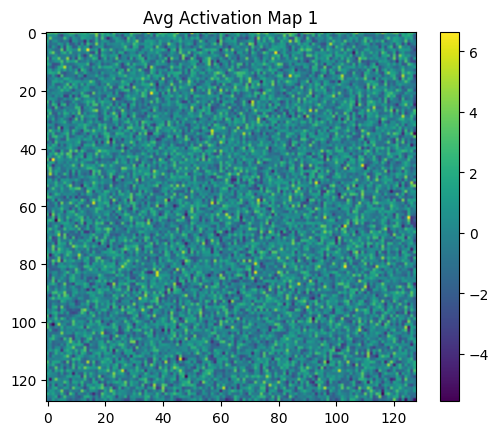

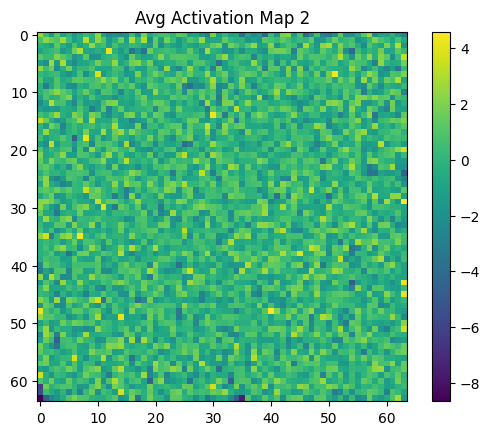

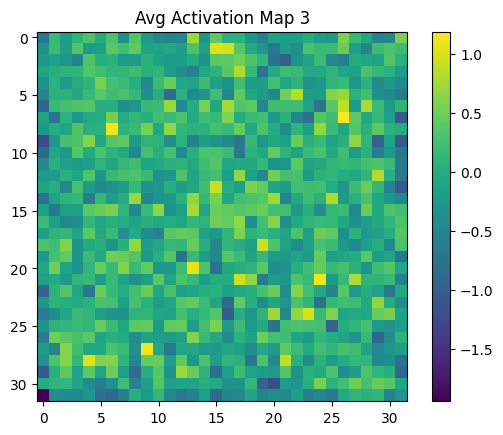

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    feats = backbone(dummy)
    for i, fmap in enumerate(feats):
        fmap_mean = fmap.squeeze().mean(dim=0).cpu()
        plt.imshow(fmap_mean, cmap="viridis")
        plt.title(f"Avg Activation Map {i+1}")
        plt.colorbar()
        plt.show()


# Anchor Configurations

In [ ]:
import math

In [ ]:
def generate_anchors(feature_map_size, stride, scales, ratios, image_size=512):
  anchors = []
  fm_h, fm_w = feature_map_size

  for i in range(fm_h):
    for j in range(fm_w):
      cx = (j + 0.5) * stride
      cy = (i + 0.5) * stride

      for scale in scales:
        for ratio in ratios:
          w = image_size * scale * np.sqrt(ratio)
          h = image_size * scale / np.sqrt(ratio)

          anchors.append([cx, cy, w, h])

  return torch.tensor(anchors)


# Detection Heads

The detection head module consists of two parallel convolutional branches.

First branch is for class prediction for every anchor box.

The second branch is for bounding box regression per anchor box

For every feature map, it predicts
- Class (B, AxC, H, W): Raw class scores per anchor

- BBox (B, Ax4, H, W): Offsets from anchors per anchor. This is how much the prefixed anchor boxes should be moved to try to fit the pothole.

### Class Prediction for every anchor box
This output tensor has the shape (B, A x C, H, W)

B = Batch Size

A = Number of anchors per spatial location

C = Number of object classes (Only 1 in this case for potholes)

### Bounding Box Regression for every anchor box

This output tesnor has the shape (B, A x 4, H, W)

In [ ]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()

        self.shared_conv = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
          nn.ReLU()
      )

        self.class_head = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, num_anchors * num_classes, kernel_size=1),

        )

        # Initialize biases to 0.005
        # This is to make the classifier start pessimistic instead of spitting out ~ 0.5 confidence for every anchor from the very beginning.
        # This is inspired by RetinaNet

        with torch.no_grad():
          last = self.class_head[-1]  # final Conv2d that outputs num_anchors * num_classes
          assert isinstance(last, nn.Conv2d)
          prior_prob = 0.005
          bias = -math.log((1 - prior_prob) / prior_prob)  # ≈ -4.595
          nn.init.constant_(last.bias, bias)

        self.bbox_head = nn.Sequential(
          nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1),
          nn.ReLU(),
          nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
        )


    def forward(self, x):
        x = self.shared_conv(x)
        class_out = self.class_head(x)  # (B, k, H, W)
        bbox_out = self.bbox_head(x)    # (B, 4k, H, W)
        return class_out, bbox_out


In [ ]:
def rearrange_outputs(class_out, bbox_out, num_classes):
  # This rearranges outputs tensors

  # Classification goes to [B, N, C] [Batch Size, # of Anchors, Object Classes]
  # Regression goes to [B, N, 4]

  B, _, H, W = class_out.shape
  class_out = class_out.permute(0, 2, 3, 1).reshape(B, -1, num_classes)  # [B, N, C]
  bbox_out = bbox_out.permute(0, 2, 3, 1).reshape(B, -1, 4)          # [B, N, 4]
  return class_out, bbox_out

## Sanity Check: Forward Pass Shape

In [ ]:
B, C, H, W = fmap.shape
num_anchors = 9 # This is k
num_classes = 2
head = DetectionHead(in_channels=C, num_anchors=num_anchors, num_classes=num_classes)
class_out, bbox_out = head(fmap)

print("Raw class output:", class_out.shape)  # [B, k×C, H, W]
print("Raw bbox output: ", bbox_out.shape)  # [B, k×4, H, W]

class_out, bbox_out = rearrange_outputs(class_out, bbox_out, num_classes)
print("Rearranged class:", class_out.shape)  # [B, N, C]
print("Rearranged bbox: ", bbox_out.shape)  # [B, N, 4]

assert class_out.shape[1] == bbox_out.shape[1] == num_anchors * H * W

print("Assertion correct")

probs = torch.softmax(class_out[0], dim=-1)
print("Top 5 class probs:", probs.max(dim=-1).values[:5])

Raw class output: torch.Size([1, 18, 32, 32])
Raw bbox output:  torch.Size([1, 36, 32, 32])
Rearranged class: torch.Size([1, 9216, 2])
Rearranged bbox:  torch.Size([1, 9216, 4])
Assertion correct
Top 5 class probs: tensor([0.5060, 0.5015, 0.5015, 0.5034, 0.5031], grad_fn=<SliceBackward0>)


In [ ]:
probs = torch.softmax(class_out[0], dim=-1)
print("Top 5 class probs:", probs.max(dim=-1).values[:5])


Top 5 class probs: tensor([0.5060, 0.5015, 0.5015, 0.5034, 0.5031], grad_fn=<SliceBackward0>)


# Box Decoder

From the anchor generation and


The bounding box offsets follow the format [tx, ty, tw, th]

We need to obtain the final bounding box in image coordinates, utilizing these mathematical equations from the SSD paper.

$$x_{center} = t_x * w_a + x_a$$

$$y_{center} = t_y * h_a + y_a$$

$$w_{box} = exp(t_w) * w_a$$

$$h_{box} = exp(t_h) * h_a$$





In [ ]:
import torch

def decode_boxes(pred_offsets, anchors):
  # Decodes predicted offsets back into bounding box coordinates into the corner format

  # For a given fixed anchor and predicted offsets, output the decoded bounding boxes in (x1, y1, x2, y2) format in shape [N, 4]
  variances = [0.1, 0.2]

  # Mention that this variance term is from the paper.

  anchor_cx, anchor_cy, anchor_w, anchor_h = anchors[:, 0], anchors[:, 1], anchors[:, 2], anchors[:, 3]
  tx, ty, tw, th = pred_offsets[:, 0], pred_offsets[:, 1], pred_offsets[:, 2], pred_offsets[:, 3]

  # print("The shape of anchor_w is ", anchor_w.shape)
  # print("The shape of tx is ", tx.shape)


  pred_cx = tx * anchor_w * variances[0] + anchor_cx
  pred_cy = ty * anchor_h * variances[0] + anchor_cy
  # Clamp the inputs to exp to prevent numerical instability
  pred_w  = torch.exp(torch.clamp(tw * variances[1], max=10)) * anchor_w
  pred_h  = torch.exp(torch.clamp(th * variances[1], max=10)) * anchor_h

  x1 = pred_cx - pred_w / 2
  y1 = pred_cy - pred_h / 2
  x2 = pred_cx + pred_w / 2
  y2 = pred_cy + pred_h / 2

  decoded_boxes = torch.stack([x1, y1, x2, y2], dim=1)
  return decoded_boxes

# Dummy Data for Sanity Check

In [ ]:
import torch

# Dummy anchor (center format): cx, cy, w, h
anchors = torch.tensor([
    [100.0, 100.0, 40.0, 40.0],
    [200.0, 150.0, 60.0, 30.0]
], dtype=torch.float32)

# Dummy predicted offsets (tx, ty, tw, th)
pred_offsets = torch.tensor([
    [0.0, 0.0, 0.0, 0.0],   # Should decode to anchor 1 exactly
    [0.1, -0.2, 0.3, -0.1]  # Some shifts/scaling
], dtype=torch.float32)

# Dummy image dimensions
image_width, image_height = 512, 512

# Dummy GT boxes (corner format): x1, y1, x2, y2
gt_boxes = torch.tensor([
    [80.0, 80.0, 120.0, 120.0],
    [170.0, 140.0, 230.0, 160.0]
], dtype=torch.float32)


In [ ]:
# Check shape of decoded boxes

decoded = decode_boxes(pred_offsets, anchors)
print("Decoded shape:", decoded.shape)

Decoded shape: torch.Size([2, 4])


In [ ]:
print(decoded[0])  # Should be close to [80.0, 80.0, 120.0, 120.0]


tensor([ 80.,  80., 120., 120.])


In [ ]:
from torchvision.ops import box_iou

ious = box_iou(decoded, gt_boxes)  # Shape: [2, 2]
print("IoU matrix:\n", ious)


IoU matrix:
 tensor([[1.0000, 0.0000],
        [0.0000, 0.6405]])


# Loss Function

The loss function

1. Match anchros to ground truth boxes (Based on IoU)

IoU: Intersection over Union

2. Compute losses
- Localization Loss
- Classification Loss (Focal Loss)


### Computing IoU


This function computes the IoU between two sets of boxes

**Input**: Anchor box and Ground Truth Box

Procedure: For every anchor box, it checks how much it overlaps with every ground truth box

**Output**: [N, M] matrix where iou[i, j] indicates how well anchor i matches ground truth j.

This is the pairwise IoU between each predicted anchor and ground truth box.

This IoU is used to assign anchors to the best matching ground truth target.

In [ ]:
def compute_iou(boxes1, boxes2):
  area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(0) # Just an x*y calculation
  area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(0)

  lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N, M, 2]
  rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N, M, 2]
  wh = (rb - lt).clamp(min=0)
  inter = wh[:, :, 0] * wh[:, :, 1]

  union = area1[:, None] + area2 - inter
  iou = inter / (union + 1e-6)
  # print("IoU shape:", iou.shape)  # [N, M]
  return iou  # [N, M]

In [ ]:
def convert_cxcy_to_xy(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - w/2
    y1 = cy - h/2
    x2 = cx + w/2
    y2 = cy + h/2
    return torch.stack([x1, y1, x2, y2], dim=-1)


Since the model learns to predict offsets relative to fixed anchor boxes, it should convert ground truth boxes to offsets.

In [ ]:
def encode_boxes(ground_truth_boxes, anchors, variances=(0.1, 0.2)):
    eps = 1e-6
    gt_cx = (ground_truth_boxes[:, 0] + ground_truth_boxes[:, 2]) / 2
    gt_cy = (ground_truth_boxes[:, 1] + ground_truth_boxes[:, 3]) / 2
    gt_w  = (ground_truth_boxes[:, 2] - ground_truth_boxes[:, 0]).clamp(min=eps)
    gt_h  = (ground_truth_boxes[:, 3] - ground_truth_boxes[:, 1]).clamp(min=eps)

    anc_cx, anc_cy, anc_w, anc_h = anchors[:, 0], anchors[:, 1], anchors[:, 2], anchors[:, 3]

    tx = ((gt_cx - anc_cx) / anc_w) / variances[0]
    ty = ((gt_cy - anc_cy) / anc_h) / variances[0]
    tw = torch.log((gt_w / anc_w).clamp(min=eps)) / variances[1]
    th = torch.log((gt_h / anc_h).clamp(min=eps)) / variances[1]

    return torch.stack([tx, ty, tw, th], dim=-1)


## Computing SSD Loss

This takes in all of the following information

- Predicted class logits
- Predicted offset values
- Anchor boxes
- Ground truth boxes
- Ground truth labels


Returns the total loss.

## Hard Negative Mining

The predefined anchor boxes will naturally introduce lots of negative anchors. This may skew the loss calculations, so the model will only select the highest classificaiton losses.

We only want to use the hardest background eaxmples during training.

We should compute classification loss for every negative anchor, and sort them by *how bad* the model is doing. We will select the top-k hardest negatives

## Different losses the team has tried

For Classificaion Loss, we tried:
- Binary Cross Entropy
- Focal Loss
- Varifocal Loss


For Box Regression/Localization Loss, we tried
- Smooth L1 Loss
- GIoU Loss
- CIoU Loss

The final verdict was to utilize SmoothL1Loss for the first 10 epochs and CIoU Loss for the rest.

In [ ]:
import torch
import torch.nn.functional as F

def focal_loss_with_logits(pred_logits, targets, alpha=0.25, gamma=2.0, reduction='none'):
    prob = torch.sigmoid(pred_logits)
    ce_loss = F.binary_cross_entropy_with_logits(pred_logits, targets, reduction='none')

    p_t = prob * targets + (1 - prob) * (1 - targets)
    modulating_factor = (1 - p_t) ** gamma

    alpha_factor = targets * alpha + (1 - targets) * (1 - alpha)
    focal_loss = alpha_factor * modulating_factor * ce_loss

    if reduction == 'mean':
        return focal_loss.mean()
    elif reduction == 'sum':
        return focal_loss.sum()
    else:
        return focal_loss

In [ ]:
def varifocal_loss_with_logits(pred_logits, target_scores, alpha=0.75, gamma=2.0):
    pred_prob = torch.sigmoid(pred_logits)

    pos_loss = target_scores * F.binary_cross_entropy_with_logits(
        pred_logits, target_scores, reduction="none"
    )
    neg_loss = (
        (1 - target_scores) *
        (pred_prob ** gamma) *
        F.binary_cross_entropy_with_logits(pred_logits, target_scores, reduction="none")
    )

    return alpha * pos_loss + (1 - alpha) * neg_loss  # no reduction


In [ ]:
def ciou_loss(pred_boxes, target_boxes, reduction='sum'):
    # pred/target are xyxy, shape [M,4]
    eps = 1e-7

    # IoU calculation
    x1 = torch.max(pred_boxes[:,0], target_boxes[:,0])
    y1 = torch.max(pred_boxes[:,1], target_boxes[:,1])
    x2 = torch.min(pred_boxes[:,2], target_boxes[:,2])
    y2 = torch.min(pred_boxes[:,3], target_boxes[:,3])
    inter = (x2 - x1).clamp(min=0) * (y2 - y1).clamp(min=0)

    area_p = (pred_boxes[:,2] - pred_boxes[:,0]).clamp(min=0) * (pred_boxes[:,3] - pred_boxes[:,1]).clamp(min=0)
    area_t = (target_boxes[:,2] - target_boxes[:,0]).clamp(min=0) * (target_boxes[:,3] - target_boxes[:,1]).clamp(min=0)
    union  = area_p + area_t - inter + eps
    iou    = inter / union

    # Smallest enclosing box diagonal squared (c2)
    cx1 = torch.min(pred_boxes[:,0], target_boxes[:,0])
    cy1 = torch.min(pred_boxes[:,1], target_boxes[:,1])
    cx2 = torch.max(pred_boxes[:,2], target_boxes[:,2])
    cy2 = torch.max(pred_boxes[:,3], target_boxes[:,3])
    c2  = (cx2 - cx1).clamp(min=0)**2 + (cy2 - cy1).clamp(min=0)**2 + eps

    # Center distance squared (rho2)
    px = (pred_boxes[:,0] + pred_boxes[:,2]) / 2
    py = (pred_boxes[:,1] + pred_boxes[:,3]) / 2
    tx = (target_boxes[:,0] + target_boxes[:,2]) / 2
    ty = (target_boxes[:,1] + target_boxes[:,3]) / 2
    rho2 = (px - tx)**2 + (py - ty)**2

    # Aspect ratio consistency term (v) and weighting factor (alpha)
    pw = (pred_boxes[:,2] - pred_boxes[:,0]).clamp(min=eps)
    ph = (pred_boxes[:,3] - pred_boxes[:,1]).clamp(min=eps)
    tw = (target_boxes[:,2] - target_boxes[:,0]).clamp(min=eps)
    th = (target_boxes[:,3] - target_boxes[:,1]).clamp(min=eps)

    v = (4 / (torch.pi**2)) * (torch.atan(tw / th) - torch.atan(pw / ph))**2
    with torch.no_grad():
        alpha = v / (1 - iou + v + eps)

    # CIoU formula
    ciou = iou - (rho2 / c2) - alpha * v
    loss = 1.0 - ciou

    if reduction == 'sum':
        return loss.sum()
    elif reduction == 'mean':
        return loss.mean()
    else:
        return loss


In [ ]:
# (1) add near the top of your loss file (once)
def giou_loss(pred_boxes, target_boxes, reduction='sum'):
    # pred/target are xyxy, shape [M,4]
    x1 = torch.max(pred_boxes[:,0], target_boxes[:,0])
    y1 = torch.max(pred_boxes[:,1], target_boxes[:,1])
    x2 = torch.min(pred_boxes[:,2], target_boxes[:,2])
    y2 = torch.min(pred_boxes[:,3], target_boxes[:,3])
    inter = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)

    area_p = (pred_boxes[:,2]-pred_boxes[:,0]).clamp(min=0) * (pred_boxes[:,3]-pred_boxes[:,1]).clamp(min=0)
    area_t = (target_boxes[:,2]-target_boxes[:,0]).clamp(min=0) * (target_boxes[:,3]-target_boxes[:,1]).clamp(min=0)
    union  = area_p + area_t - inter + 1e-7
    iou    = inter / union

    cx1 = torch.min(pred_boxes[:,0], target_boxes[:,0])
    cy1 = torch.min(pred_boxes[:,1], target_boxes[:,1])
    cx2 = torch.max(pred_boxes[:,2], target_boxes[:,2])
    cy2 = torch.max(pred_boxes[:,3], target_boxes[:,3])
    c_area = (cx2-cx1).clamp(min=0) * (cy2-cy1).clamp(min=0) + 1e-7

    giou = iou - (c_area - union) / c_area
    loss = 1.0 - giou
    return loss.sum() if reduction=='sum' else (loss.mean() if reduction=='mean' else loss)


In [ ]:
def center_sampling_gate_by_gt(anchor_centers_xy, gt_boxes_xyxy, center_frac=0.5):
    """
    anchor_centers_xy: [N,2] (pixels)
    gt_boxes_xyxy:     [M,4] (pixels)
    center_frac: size of central square as a fraction of min(w,h).
                 e.g., 0.5 => square side = 0.5 * min(w,h)
    Returns: mask [M,N]: True if anchor center is inside the GT's central square.
    """
    device = anchor_centers_xy.device
    M, N = gt_boxes_xyxy.size(0), anchor_centers_xy.size(0)

    gx = 0.5 * (gt_boxes_xyxy[:, 0] + gt_boxes_xyxy[:, 2])  # [M]
    gy = 0.5 * (gt_boxes_xyxy[:, 1] + gt_boxes_xyxy[:, 3])  # [M]
    gw = (gt_boxes_xyxy[:, 2] - gt_boxes_xyxy[:, 0]).clamp(min=1e-6)
    gh = (gt_boxes_xyxy[:, 3] - gt_boxes_xyxy[:, 1]).clamp(min=1e-6)

    side = center_frac * torch.minimum(gw, gh)             # [M]
    x1 = gx - 0.5 * side
    y1 = gy - 0.5 * side
    x2 = gx + 0.5 * side
    y2 = gy + 0.5 * side

    acx = anchor_centers_xy[:, 0][None, :].expand(M, N)    # [M,N]
    acy = anchor_centers_xy[:, 1][None, :].expand(M, N)    # [M,N]

    in_x = (acx >= x1[:, None]) & (acx <= x2[:, None])
    in_y = (acy >= y1[:, None]) & (acy <= y2[:, None])
    return in_x & in_y                                     # [M,N]


In [ ]:
def ssd_loss(pred_cls, pred_offsets, anchors, gt_boxes, gt_labels, iou_threshold=0.5, neg_ratio=3.0, epoch=0):
  device = pred_cls.device

  # ============ Convert the prediction to bounding box corners ===========

  decoded_anchors = convert_cxcy_to_xy(anchors.to(pred_offsets.device))

  # ============= No Ground Truths! =================== #
  if gt_boxes.numel() == 0:
      labels = torch.zeros(pred_cls.shape[0], device=device)
      # using focal loss function
      cls_loss = focal_loss_with_logits(pred_cls[:, 0], labels, alpha=0.75, gamma=1.5, reduction='none')

      target_scores = torch.zeros_like(labels)  # same shape as labels
      # target_scores[pos_mask] = best_gt_iou[pos_mask]  # IoU for positives
      # cls_loss = varifocal_loss_with_logits(pred_cls[:, 0], target_scores, alpha=0.75, gamma=2.0)


      #cls_loss = F.binary_cross_entropy_with_logits(pred_cls[:, 0], labels, reduction='none')

      # hard negative mining: Cap the the amount of negatives to stabilize early epochs
      max_negs = min(512, cls_loss.numel())  # tune if you want
      if max_negs > 0:
          _, neg_idx = cls_loss.topk(max_negs, largest=True)
          cls_loss_final = cls_loss[neg_idx].mean()  # mean keeps scale stable
      else:
          cls_loss_final = torch.tensor(0.0, device=device)

      return cls_loss_final, torch.tensor(0.0, device=device)  # no loc loss

  if gt_boxes.numel() > 0:
    # print(" GT labels:", gt_labels)
    areas = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    # print("GT Box Area Stats:", areas.min().item(), areas.max().item(), areas.mean().item())


  # Compute the ious for the anchor predictions
  # --- IoU matrix: shape [N_anchors, M_gt] (your compute_iou returns this) ========
  ious = compute_iou(decoded_anchors, gt_boxes)              # [N,M]
  best_gt_iou, best_gt_idx = ious.max(dim=1)                 # [N], [N]

  # Anchor centers (pixels). If your anchors are cx,cy,w,h in pixels already:
  anchor_centers = anchors[:, :2].to(pred_cls.device)        # [N,2]

  # Center-sampling gate per GT -> [M,N], we want [N,M], so transpose later
  gate_MN = center_sampling_gate_by_gt(anchor_centers, gt_boxes)  # [M,N]
  gate = gate_MN.t()                                              # [N,M]

  pos_mask = torch.zeros_like(best_gt_iou, dtype=torch.bool)      # [N]

  topk_per_gt = 9  # tunable; 6–12 are common

  # For each GT, pick top-k among anchors whose centers are inside the gate.
  for g in range(gt_boxes.size(0)):
      eligible = gate[:, g]                # [N] bool
      if eligible.any():
          ious_g = ious[:, g].clone()
          ious_g[~eligible] = -1.0         # mask out non-eligible anchors
          k = min(topk_per_gt, int(eligible.sum().item()))
          if k > 0:
              topk_idx = torch.topk(ious_g, k=k, largest=True).indices
              pos_mask[topk_idx] = True
      else:
          # Fallback: no eligible anchors in gate; take the single best IoU
          top1 = torch.argmax(ious[:, g])
          pos_mask[top1] = True

  forced_count = 0
  for g in range(gt_boxes.size(0)):
      best_anchor_idx = torch.argmax(ious[:, g])
      if not pos_mask[best_anchor_idx]:
          forced_count += 1
          pos_mask[best_anchor_idx] = True


  # HARD CODED
  pos_iou_thresh = 0.5   # positive if IoU >= 0.6
  neg_iou_thresh = 0.4   #   if IoU < 0.4

  # Also keep classic IoU positives as a backstop (prevents super-low-IoU matches)
  # pos_mask |= (best_gt_iou >= iou_threshold)
  pos_mask |= (best_gt_iou >= pos_iou_thresh)
  ignore_mask = (best_gt_iou >= neg_iou_thresh) & (best_gt_iou < pos_iou_thresh)


  num_pos = pos_mask.sum().clamp(min=1)


  # ============= Ground Truths Present! =================== #

  # print(f"# Positive anchors matched: {pos_mask.sum().item()}")
  num_pos = pos_mask.sum().clamp(min=1)

  matched_gt_boxes = gt_boxes[best_gt_idx]
  target_offsets = encode_boxes(matched_gt_boxes, anchors.to(matched_gt_boxes.device))
  # if pos_mask.sum() > 0:
  #     print("Sample target offset:", target_offsets[pos_mask][0])
  # else:
  #     print("No positive anchors matched.")
  # print("Should print pos_indices")


  # make sure all three are on the SAME device BEFORE indexing
  device = pred_offsets.device

  anchors_d = anchors.to(device)                 # move first, then index
  matched_gt_boxes = gt_boxes[best_gt_idx].to(device)  # move first, then index

  # now safe:
  pred_xyxy = decode_boxes(pred_offsets[pos_mask], anchors_d[pos_mask])
  tgt_xyxy  = matched_gt_boxes[pos_mask]  # already xyxy


  # ================== Regression Loss ==================
  if epoch < 10:
    loc_loss = F.smooth_l1_loss(pred_offsets[pos_mask], target_offsets[pos_mask], reduction='sum')
  else:
    loc_loss = ciou_loss(pred_xyxy, tgt_xyxy,reduction='sum')

  # ================= Classification Loss ===================
  labels = torch.zeros(pred_cls.size(0), dtype=torch.float, device=pred_cls.device)
 # Get [N]
  matched_labels = gt_labels[best_gt_idx]
  labels[pos_mask] = gt_labels[best_gt_idx[pos_mask]].float()


  # cls_loss = F.binary_cross_entropy_with_logits(pred_cls[:, 0], labels, reduction='none')
  cls_loss = focal_loss_with_logits(pred_cls[:, 0], labels, alpha=0.75, gamma=1.5, reduction='none')

  target_scores = torch.zeros(pred_cls.size(0), dtype=torch.float, device=pred_cls.device)
  target_scores[pos_mask] = best_gt_iou[pos_mask].float()  # IoU for positives

  # cls_loss = varifocal_loss_with_logits(pred_cls[:, 0], target_scores, alpha=0.75, gamma=2.0)

  # Hard Negative Mining
  neg_mask = ~pos_mask & ~ignore_mask
  # neg_mask = ~pos_mask
  num_neg = (neg_ratio * num_pos).int()

  # Avoid calling topk on empty tensors
  # neg_loss = cls_loss[neg_mask]
  # _, neg_idx = neg_loss.topk(min(num_neg.item(), neg_loss.numel()), largest=True)
  # cls_loss_final = cls_loss[pos_mask].sum() + neg_loss[neg_idx].sum()

  neg_loss = cls_loss[neg_mask]
  if neg_loss.numel() > 0:
      k = min(num_neg.item(), neg_loss.numel())
      _, neg_idx = neg_loss.topk(k, largest=True)
      cls_loss_final = cls_loss[pos_mask].sum() + neg_loss[neg_idx].sum()
  else:
      cls_loss_final = cls_loss[pos_mask].sum()


  # total_loss = (cls_loss_final + loc_loss) / num_pos
  # return total_loss

  cls_loss_final /= num_pos
  loc_loss /= num_pos


  if not hasattr(ssd_loss, "_printed_IoU"):
      print("\n Positive anchors:", pos_mask.sum().item(), "out of", anchors.shape[0])
      print(" Max IoU with GT:", best_gt_iou.max().item())
      ssd_loss._printed_IoU = True


  return cls_loss_final, loc_loss

In [ ]:

dummy_cls = torch.randn(5000, 1)
dummy_offsets = torch.randn(5000, 4)
dummy_anchors = torch.rand(5000, 4) * 512
dummy_anchors[0] = torch.tensor([125., 125., 50., 50.])  # Matches GT box

# This dummy places the box at exactly where the gt box is

dummy_gt_boxes = torch.tensor([[100., 100., 150., 150.]], dtype=torch.float32)
dummy_gt_labels = torch.tensor([1], dtype=torch.long)

cls_loss, loc_loss = ssd_loss(dummy_cls, dummy_offsets, dummy_anchors, dummy_gt_boxes, dummy_gt_labels)
print("cls_loss:", cls_loss.item(), "loc_loss:", loc_loss.item())


## Postprocessing

For each image, we need to perform the following during inference time:
1. Decode bounding boxes from predicted offsets
2. Apply sigmoid to classificaiton scores
3. Filter out low-confidence scores below the threshold
4. Apply NMS to remove duplicates
5. Return final boxes + scores

### Non-Maximum Suppression (NMS)



Like how we removed duplicates in pre-processing, this is required in post-processing when the model does inferencing.

The output of the model is the following

pred_cls:    [N, 1]  ← sigmoid scores per anchor (objectness)

pred_boxes:  [N, 4]  ← decoded [x1, y1, x2, y2] box for each anchor

In [ ]:
from torchvision.ops import nms

In [ ]:
# show_message is a toggle to show messages during postprocess
def postprocess(pred_cls_logits, pred_offsets, anchors, conf_threshold=0.9, nms_threshold=0.3, top_k=30, show_message = True):
    assert pred_cls_logits.shape[0] == pred_offsets.shape[0] == anchors.shape[0]
    # Squeeze batch dim (if exists)
    if pred_cls_logits.dim() == 3:
        pred_cls_logits = pred_cls_logits.squeeze(0)  # [N, 1]
    if pred_offsets.dim() == 3:
        pred_offsets = pred_offsets.squeeze(0)
    if anchors.dim() == 3:
        anchors = anchors.squeeze(0)

    # Shape check
    assert pred_cls_logits.shape[0] == pred_offsets.shape[0] == anchors.shape[0], \
        f"Inconsistent shapes: cls={pred_cls_logits.shape}, offsets={pred_offsets.shape}, anchors={anchors.shape}"

    # Apply sigmoid and squeeze final class dim
    scores = torch.sigmoid(pred_cls_logits.squeeze(-1))  # [N]

    # print("scores:", scores.shape)
    # print("pred_offsets:", pred_offsets.shape)
    # print("anchors:", anchors.shape)
    if (show_message):
      print(f"Score stats → min: {scores.min():.3f}, max: {scores.max():.3f}, mean: {scores.mean():.3f}")

    # Filter by confidence
    conf_mask = scores > conf_threshold
    # print("conf_mask:", conf_mask.shape, "→ Num kept:", conf_mask.sum().item())

    if conf_mask.sum() == 0:
        return torch.empty((0, 4)), torch.empty((0,))

    scores = scores[conf_mask]
    filtered_offsets = pred_offsets[conf_mask]
    filtered_anchors = anchors[conf_mask]

    decoded_boxes = decode_boxes(filtered_offsets, filtered_anchors.to(filtered_offsets.device))

    # Filter out invalid boxes before NMS
    valid_boxes_mask = (decoded_boxes[:, 2] > decoded_boxes[:, 0]) & (decoded_boxes[:, 3] > decoded_boxes[:, 1])
    decoded_boxes = decoded_boxes[valid_boxes_mask]
    scores = scores[valid_boxes_mask]

    if decoded_boxes.shape[0] == 0:
        return torch.empty((0, 4)), torch.empty((0,))

    decoded_boxes = decoded_boxes.to(dtype=torch.float32)
    scores = scores.to(dtype=torch.float32)

    # limit to the top 10000 boxes before nms
    pre_nms_topk = 600
    if scores.numel() > pre_nms_topk:
        topk_idx = scores.topk(pre_nms_topk).indices
        decoded_boxes = decoded_boxes[topk_idx]
        scores = scores[topk_idx]

    # Apply NMS
    if decoded_boxes.shape[0] == 0:
      return torch.empty((0,4)), torch.empty((0,))  # No detections
    keep_idx = nms(decoded_boxes, scores, iou_threshold=nms_threshold)
    keep_idx = keep_idx[:top_k]

    final_boxes = decoded_boxes[keep_idx]
    final_scores = scores[keep_idx]

    if (show_message):
      print("final_boxes:", final_boxes.shape, "→ Num kept:", final_boxes.shape[0])

    return final_boxes, final_scores

# The SSD Architecture

In [ ]:
# class SSD(nn.Module):
#   def __init__(self, backbone, detection_heads):
#     super().__init__()
#     self.backbone = backbone
#     self.detection_heads = detection_heads

#   def forward(self, x):
#     # Step 1: Put image through backbone to extract features maps
#     feature_maps = self.backbone(x)

#     # print("Number of feature maps:", len(feature_maps))
#     # for i, fmap in enumerate(feature_maps):
#         # print(f"Feature map {i}: shape {fmap.shape}")


#     all_cls_logits = []
#     all_bbox_deltas = []

#     for fmap, head in zip(feature_maps, self.detection_heads):
#       cls_logits, bbox_deltas = head(fmap)

#       # Batch Size
#       B = cls_logits.shape[0]
#       A = cls_logits.shape[1] // 1
#       H, W = cls_logits.shape[2:]

#       cls_logits = cls_logits.permute(0, 2, 3, 1).reshape(B, -1, 1)
#       bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).reshape(B, -1, 4)

#       all_cls_logits.append(cls_logits)
#       all_bbox_deltas.append(bbox_deltas)

#     # final_cls_logits = torch.cat(all_cls_logits, dim=1).reshape(-1, 1)
#     # final_bbox_deltas = torch.cat(all_bbox_deltas, dim=1).reshape(-1, 4)

#     final_cls_logits = torch.cat(all_cls_logits, dim=1)      # shape: [B, total_anchors, 1]
#     final_bbox_deltas = torch.cat(all_bbox_deltas, dim=1)

#     return final_cls_logits, final_bbox_deltas


In [ ]:
# File: your SSD file
class SSD(nn.Module):
    def __init__(self, backbone, fpn, detection_heads):
        super().__init__()
        self.backbone = backbone
        self.fpn = fpn                    # <-- add this
        self.detection_heads = detection_heads

    def forward(self, x):
        # 1) Backbone: C2, C3, C4
        c2, c3, c4 = self.backbone(x)

        # 2) FPN: P2, P3, P4 (all fpn_ch channels)
        p2, p3, p4 = self.fpn(c2, c3, c4)
        feature_maps = [p2, p3, p4]       # <-- heads must match this order/length

        all_cls_logits, all_bbox_deltas = [], []
        for fmap, head in zip(feature_maps, self.detection_heads):
            cls_logits, bbox_deltas = head(fmap)
            B = cls_logits.shape[0]
            cls_logits  = cls_logits.permute(0, 2, 3, 1).reshape(B, -1, 1)
            bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).reshape(B, -1, 4)
            all_cls_logits.append(cls_logits)
            all_bbox_deltas.append(bbox_deltas)

        final_cls_logits  = torch.cat(all_cls_logits,  dim=1)  # [B, N, 1]
        final_bbox_deltas = torch.cat(all_bbox_deltas, dim=1)  # [B, N, 4]
        return final_cls_logits, final_bbox_deltas


## More Sanity checking

## Training Loop

In [ ]:
from torchvision.transforms.functional import to_pil_image

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

In [ ]:
def set_backbone_bn_eval(model):

    #Freeze running mean/var for BatchNorm layers in the backbone to keep gamma/beta trainable.

    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()                # stop updating running stats
            for p in m.parameters():
                p.requires_grad = True  # keep affine (gamma/beta) trainable

In [ ]:
def freeze_all_batchnorms(module: nn.Module):
    """
    Sets every BatchNorm layer to
     eval mode and stops it from updating
    running stats and gradients. Great for tiny-batch stability.
    """
    for m in module.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

In [ ]:
import torch

def evaluate_model(model, dataloader, device, decode_fn, conf_threshold=0.3, iou_threshold=0.5):
    """
    model: SSD-like model returning (pred_cls_batch, pred_offsets_batch)
    dataloader: yields (images, gt_boxes_batch, gt_labels_batch)
    device: torch.device
    decode_fn: function to convert pred_offsets -> boxes in xyxy format
    """

    model.eval()
    results = []

    with torch.no_grad():
        for batch_idx, (images, gt_boxes_batch, gt_labels_batch) in enumerate(dataloader):
            # Move to device
            images = [img.to(device) for img in images]

            # Forward pass
            pred_cls_batch, pred_offsets_batch = model(images)

            for img_idx in range(len(images)):
                # Decode predicted offsets to boxes
                boxes = decode_fn(pred_offsets_batch[img_idx])  # [N, 4] xyxy format

                # Get class scores (skip background class idx=0)
                scores, labels = torch.softmax(pred_cls_batch[img_idx], dim=-1)[:, 1:].max(dim=1)

                # Filter by confidence
                keep = scores > conf_threshold
                boxes = boxes[keep].cpu()
                scores = scores[keep].cpu()

                # Apply NMS
                if len(boxes) > 0:
                    nms_keep = torch.ops.torchvision.nms(boxes, scores, iou_threshold)
                    boxes = boxes[nms_keep]
                    scores = scores[nms_keep]

                results.append({
                    "batch_idx": batch_idx,
                    "image_idx_in_batch": img_idx,
                    "num_boxes": len(boxes),
                    "mean_conf": scores.mean().item() if len(scores) > 0 else 0.0,
                    "max_conf": scores.max().item() if len(scores) > 0 else 0.0
                })

    return results


In [ ]:
from collections import defaultdict


In [ ]:
from torchvision.transforms.functional import to_pil_image

def train_model(model, dataloader, visloader, valloader, anchors, device, num_epochs=10, lr=1e-3):
  # Detection heads Parameters
  head_params = list(model.detection_heads.parameters())

  # FPN params
  fpn_params = list(model.fpn.parameters())

  # Backbone high-level layers (C4 & C5 trainable only)
  # backbone_trainable_params = list(model.backbone.c4.parameters())

  backbone_trainable_params = list(model.backbone.stage1.parameters()) \
                            + list(model.backbone.c3.parameters()) \
                            + list(model.backbone.c4.parameters())
  warmup_epochs = 3
  base_backbone_lr = 5e-5
  base_head_lr = lr

  optimizer = torch.optim.Adam(
      [
          {'params': backbone_trainable_params, 'lr': base_backbone_lr},
          {'params': fpn_params, 'lr': base_head_lr},
          {'params': head_params, 'lr': base_head_lr},
      ],
      weight_decay=1e-5
  )

  warmup_sched = torch.optim.lr_scheduler.LambdaLR(
      optimizer,
      lr_lambda=lambda ep: (ep + 1) / warmup_epochs if ep < warmup_epochs else 1.0
  )
  step_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

  # ============= Loop through Epochs =============

  model.to(device)

  # set_backbone_bn_eval(model)
  # freeze_all_batchnorms(model)

  epoch_logs = defaultdict( )

  for epoch in range(num_epochs):
    model.train()
    cls_loss_total = 0.0
    loc_loss_total = 0.0

    # This follows the data loader batch size
    for images, gt_boxes_batch, gt_labels_batch in dataloader:
      images = images.to(device)
      pred_cls_batch, pred_offsets_batch = model(images)

      batch_cls_loss = 0.0
      batch_loc_loss = 0.0

      for i in range(images.size(0)):  # loop over batch
          pred_cls = pred_cls_batch[i]         # shape [N, 1]
          pred_offsets = pred_offsets_batch[i] # shape [N, 4]
          gt_boxes = gt_boxes_batch[i].to(device)
          gt_labels = gt_labels_batch[i].to(device)

          cls_loss, loc_loss = ssd_loss(pred_cls, pred_offsets, anchors, gt_boxes, gt_labels, epoch=epoch)
          batch_cls_loss += cls_loss
          batch_loc_loss += loc_loss


      # Average over batch size
      batch_cls_loss /= images.size(0)
      batch_loc_loss /= images.size(0)

      # Can tune the weighting of location losses
      total_loss = 1 * batch_cls_loss + 2 * batch_loc_loss

      optimizer.zero_grad()
      total_loss.backward()


      # Clip Gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
      optimizer.step()

      cls_loss_total += batch_cls_loss.item()
      loc_loss_total += batch_loc_loss.item()
      # print(f"Epoch {epoch+1}: Avg Cls Loss = {batch_cls_loss.item():.4f}, Avg Loc Loss = {batch_loc_loss.item():.4f}")


    print(f"[Epoch {epoch+1}] Cls Loss: {cls_loss_total:.4f}, Loc Loss: {loc_loss_total:.4f}")

    # end of epoch
    if epoch < warmup_epochs:
        warmup_sched.step()
    else:
        step_sched.step()

    # (optional) print the current LR
    curr_lrs = [group['lr'] for group in optimizer.param_groups]
    print(f"    LRs -> stage3:{curr_lrs[0]:.2e}, heads:{curr_lrs[1]:.2e}")

    # ===== Save epoch losses ======
    save_epoch_losses("training_losses.csv", epoch+1, cls_loss_total, loc_loss_total)
    # ========================== Get Validation Losses ============================= #

    model.eval()
    val_cls_total, val_loc_total, val_batches = 0.0, 0.0, 0

    with torch.no_grad():
        for images, gt_boxes_batch, gt_labels_batch in valloader:
            images = images.to(device)
            pred_cls_batch, pred_offsets_batch = model(images)

            batch_cls_loss = 0.0
            batch_loc_loss = 0.0

            for i in range(images.size(0)):
                pred_cls = pred_cls_batch[i]         # [N, 1]
                pred_offsets = pred_offsets_batch[i] # [N, 4]
                gt_boxes = gt_boxes_batch[i].to(device)
                gt_labels = gt_labels_batch[i].to(device)

                cls_loss, loc_loss = ssd_loss(pred_cls, pred_offsets, anchors, gt_boxes, gt_labels)
                batch_cls_loss += cls_loss
                batch_loc_loss += loc_loss

            batch_cls_loss /= images.size(0)
            batch_loc_loss /= images.size(0)

            val_cls_total += batch_cls_loss.item()
            val_loc_total += batch_loc_loss.item()
            val_batches += 1

    val_cls_avg = val_cls_total / max(1, val_batches)
    val_loc_avg = val_loc_total / max(1, val_batches)
    print(f"[Validation {epoch+1}] Cls Loss: {val_cls_total:.4f}, Loc Loss: {val_loc_total:.4f}")
    save_epoch_losses("validation_losses.csv", epoch+1, val_cls_total, val_loc_total)

    # =========================== Draw 6 images every 5th epoch ==================== #

    # if (epoch + 1) % 5 == 0:
    #   print("================ STARTING TRAINING EVALUATION ==============")
    #   N = 30  # Number of images to visualize
    #   count = 0

    #   model.eval()
    #   with torch.no_grad():
    #       # for images, gt_boxes_batch, gt_labels_batch in sample_pothole_loader:
    #       for images, gt_boxes_batch, gt_labels_batch in visloader:
    #           batch_size = len(images)
    #           for i in range(batch_size):
    #               print("At count ", count)
    #               if count >= N:
    #                   break  # Exit inner loop
    #               img_tensor = images[i].unsqueeze(0).to(device)
    #               gt_boxes = gt_boxes_batch[i].to(device)
    #               pred_boxes, pred_scores = run_inference(model, img_tensor, anchors, device, 0.5, 0.5)
    #               img_vis = denormalize(img_tensor[0].cpu())
    #               img_pil = to_pil_image(img_vis)
    #               draw_gt_and_preds(img_pil, gt_boxes.cpu(), pred_boxes, pred_scores, score_thresh=0.4)
    #               print(f"Sample {count}: # GT boxes: {gt_boxes.shape[0]}")
    #               count += 1
    #           if count >= N:
    #               break

      # ================== Visualization for Validation ============
    # if (epoch + 1) % 5 == 0:
    #   print("================ STARTING VALIDATION EVALUATION ==============")
    #   N = 30  # Number of images to visualize
    #   count = 0
    #   model.eval()
    #   with torch.no_grad():
    #       for images, gt_boxes_batch, gt_labels_batch in valloader:
    #           batch_size = len(images)
    #           for i in range(batch_size):
    #               print("At count ", count)
    #               if count >= N:
    #                   break  # Exit inner loop
    #               img_tensor = images[i].unsqueeze(0).to(device)
    #               gt_boxes = gt_boxes_batch[i].to(device)
    #               pred_boxes, pred_scores = run_inference(model, img_tensor, anchors, device, 0.45, 0.5)
    #               img_vis = denormalize(img_tensor[0]).cpu()
    #               img_pil = to_pil_image(img_vis)
    #               draw_gt_and_preds(img_pil, gt_boxes.cpu(), pred_boxes, pred_scores, score_thresh=0.35)
    #               print(f"Sample {count}: # GT boxes: {gt_boxes.shape[0]}")
    #               count += 1
    #           if count >= N:
    #               break

    if (epoch + 1) % 3 == 0:
      # metrics on the validation dataset
      # compute recall and precision values every 5th epoch, save to csv
      precision, recall = compute_precision_recall(model, valloader, anchors, device, conf_thresh=0.45, nms_thresh=0.5)
      # compute mAP50 value every 5th epoch, save to csv
      ap, _, _ = compute_mAP50(model, valloader, anchors, device, nms_thresh=0.5, show_graph=False)
      print(f"precision: {precision}, recall: {recall}, mAP50: {ap}")
      save_mAP50("average_precision.csv", epoch, precision, recall, ap)

    checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_cls': cls_loss_total,
        'loss_loc': loc_loss_total
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")

## Make training and validation datasets for small potholes

# Make training and validation dataset for multiple potholes

In [ ]:
from torch.utils.data import Subset


In [ ]:
# filter through entire dataset to create a dataset of only multi-boxes
# 25 single-potholes, 25 multi-potholes, 25 no potholes
single_box_count = 0
multi_box_count = 0
# multi_box_area_threshold = 600
single_box_appendices = []
multi_box_appendices = []
no_pothole_count = 0
no_pothole_appendices = []

for idx in range(len(valid_dataset)):
    print("At index, ", idx)
    print("Single boxes: ", single_box_count)
    print("Multi boxes: ", multi_box_count)
    _, gt_boxes, _ = valid_dataset[idx]

    if single_box_count >= 15 and multi_box_count >= 15 and no_pothole_count >= 15:
        print("finished loading")
        break
    # collect indicies for samples w no boxes
    if no_pothole_count < 15 and gt_boxes.shape[0] == 0 :
        no_pothole_count += 1
        no_pothole_appendices.append(idx)

    # collect indices for samples that only have small boxes

    if gt_boxes.shape[0] == 1 and single_box_count < 15:  # Has at least one pothole box
        single_box_count += 1
        single_box_appendices.append(idx)

    if gt_boxes.shape[0] > 1 and multi_box_count < 15:  # Has multiple pothole boxes
        multi_box_count += 1
        multi_box_appendices.append(idx)

multi_pothole_dataset_indices = no_pothole_appendices + single_box_appendices + multi_box_appendices
print(multi_pothole_dataset_indices)

print("Samples with no potholes:", no_pothole_appendices)
print("Samples with single pothole:", single_box_appendices)
print("Samples with multi pothole:", multi_box_appendices)


multi_val_pothole_loader = DataLoader(
    Subset(valid_dataset, multi_pothole_dataset_indices),
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn
)

visual_multi_val_pothole_loader = DataLoader(
    Subset(valid_dataset, multi_box_appendices),
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

At index,  0
Single boxes:  0
Multi boxes:  0
At index,  1
Single boxes:  0
Multi boxes:  0
At index,  2
Single boxes:  1
Multi boxes:  0
At index,  3
Single boxes:  2
Multi boxes:  0
At index,  4
Single boxes:  2
Multi boxes:  0
At index,  5
Single boxes:  3
Multi boxes:  0
At index,  6
Single boxes:  3
Multi boxes:  1
At index,  7
Single boxes:  4
Multi boxes:  1
At index,  8
Single boxes:  4
Multi boxes:  1
At index,  9
Single boxes:  5
Multi boxes:  1
At index,  10
Single boxes:  6
Multi boxes:  1
At index,  11
Single boxes:  7
Multi boxes:  1
At index,  12
Single boxes:  7
Multi boxes:  1
At index,  13
Single boxes:  7
Multi boxes:  1
At index,  14
Single boxes:  8
Multi boxes:  1
At index,  15
Single boxes:  8
Multi boxes:  1
At index,  16
Single boxes:  8
Multi boxes:  2
At index,  17
Single boxes:  8
Multi boxes:  2
At index,  18
Single boxes:  8
Multi boxes:  2
At index,  19
Single boxes:  9
Multi boxes:  2
At index,  20
Single boxes:  9
Multi boxes:  2
At index,  21
Single bo

In [ ]:
def draw_gt_and_preds(image_pil, gt_boxes, pred_boxes, pred_scores, score_thresh=0.5):
    plt.figure(figsize=(8, 8))
    plt.imshow(image_pil)
    ax = plt.gca()

    # GT boxes: Red
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    # Predicted boxes: Green
    for box, score in zip(pred_boxes, pred_scores):
        if score < score_thresh:
            continue
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x_min, y_min - 5, f"{score:.2f}", color='lime', fontsize=10)

    plt.axis('off')
    plt.title("Red = GT, Green = Predictions")
    plt.show()


## Inferencing Loop

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
import cv2

def run_inference(model, image_tensor, anchors, device, conf_thresh=0.9, nms_thresh=0.5, show_message = True):
    model.eval()
    image_tensor = image_tensor.to(device)
    anchors = anchors.to(device)

    with torch.no_grad():
        pred_cls, pred_offsets = model(image_tensor)

        pred_cls = pred_cls.squeeze(0)
        pred_offsets = pred_offsets.squeeze(0)

        decoded_boxes = decode_boxes(pred_offsets, anchors)

        # Filter out invalid boxes
        valid_boxes_mask = (decoded_boxes[:, 2] > decoded_boxes[:, 0]) & (decoded_boxes[:, 3] > decoded_boxes[:, 1])

        final_boxes, final_scores = postprocess(
            pred_cls_logits=pred_cls[valid_boxes_mask],
            pred_offsets=pred_offsets[valid_boxes_mask],
            anchors=anchors[valid_boxes_mask],
            conf_threshold=conf_thresh,
            nms_threshold=nms_thresh,
            top_k=30,
            show_message = show_message
        )
    return final_boxes.cpu(), final_scores.cpu()

## Model Evaluation
Training on 25 small potholes + 25 no pothole images

# Results Visualization

In [ ]:
def count_tp_fp_fn(pred_boxes, gt_boxes, iou_thresh = 0.5):
  tp, fp, fn = 0, 0, 0

  # check if there are no predicted boxes in the presence of
  if (gt_boxes.numel() > 0 and pred_boxes.numel() == 0):
    fn += gt_boxes.numel()
    return tp, fp, fn

  if (gt_boxes.numel() == 0 and pred_boxes.numel() > 0):
    fp += pred_boxes.numel()
    return tp, fp, fn
  if (gt_boxes.numel() == 0 and pred_boxes.numel() == 0):
    return tp, fp, fn

  # check if pred_boxes match gt_boxes
  for pred_box in pred_boxes:
    ious = box_iou(pred_box.unsqueeze(0), gt_boxes)
    max_iou, max_idx = ious.max(1)
    if max_iou.item() >= iou_thresh:
        tp += 1
    else:
        fp += 1

  # check for any boxes that were not detected
  for gt_box in gt_boxes:
    ious = box_iou(gt_box.unsqueeze(0), pred_boxes)
    max_iou, max_idx = ious.max(1)
    if max_iou.item() < iou_thresh:
        fn += 1



  return tp, fp, fn

In [ ]:
# computes precision and recall at an IOU of 0.5
def compute_precision_recall(model, dataloader, anchors, device, conf_thresh=0.7, nms_thresh=0.5):
  model.eval()
  total_tp, total_fp, total_fn = 0, 0, 0
  with torch.no_grad():
    for images, gt_boxes_batch, _ in dataloader:
      for i in range(len(images)):
        img_tensor = images[i].unsqueeze(0).to(device)
        pred_boxes, pred_scores = run_inference(model, img_tensor, anchors, device, conf_thresh, nms_thresh, show_message = False)
        tp, fp, fn = count_tp_fp_fn(pred_boxes, gt_boxes_batch[i])
        total_tp += tp
        total_fp += fp
        total_fn += fn

  if (total_tp + total_fp) == 0:
    precision = 0
  else:
    precision = total_tp / (total_tp + total_fp)

  if (total_tp + total_fn) == 0:
    recall = 0
  else:
    recall = total_tp / (total_tp + total_fn)
  return precision, recall


In [ ]:
def compute_mAP50(model, dataloader, anchors, device, nms_thresh=0.5, show_graph=False):
    model.eval()

    all_precisions = np.zeros(100)
    all_recalls = np.zeros(100)

    all_true_positives = np.zeros(100)
    all_false_negatives = np.zeros(100)
    all_false_positives = np.zeros(100)

    with torch.no_grad():
      # compute all values for confusion matrix at varying confidence thresholds
      for images, gt_boxes_batch, _ in dataloader:
          for i in range(len(images)):
              img_tensor = images[i].unsqueeze(0).to(device)
              # get as many predicted bounding boxes as possible
              pred_boxes, pred_scores = run_inference(model, img_tensor, anchors, device, 0.0, nms_thresh, show_message = False)

              # increment from 0 to 1.0 through a step of 0.01 to filter out the predicted boxes
              for j in range(100):
                conf_thresh = j*0.01

                temp_boxes = pred_boxes[pred_scores >= conf_thresh]
                tp, fp, fn = count_tp_fp_fn(temp_boxes, gt_boxes_batch[i])
                all_true_positives[j] += tp
                all_false_positives[j] += fp
                all_false_negatives[j] += fn
    # compute precisions and recalls
    all_precisions = all_true_positives / (all_true_positives + all_false_positives + np.full(100, 1e-6))
    all_recalls = all_true_positives / (all_true_positives + all_false_negatives + np.full(100, 1e-6))

    # Sort by recall
    sorted_idx = np.argsort(all_recalls)
    recalls = all_recalls[sorted_idx]
    precisions = all_precisions[sorted_idx]

    # Use 11-point interpolation to calculate AP
    ap = 0.0
    for t in np.arange(0., 1.1, 0.1):
        if np.sum(recalls >= t) == 0:
            p = 0
        else:
            p = np.max(precisions[recalls >= t])
        ap += p / 11.

    if show_graph:
        plot_precision_recall_curve(precisions, recalls)

    return ap, all_precisions, all_recalls


def plot_precision_recall_curve(precisions, recalls):
    # Convert to numpy arrays
    precisions = np.array(precisions, dtype=float)
    recalls = np.array(recalls, dtype=float)

    # Sort by recall
    sort_idx = np.argsort(recalls)
    recalls = recalls[sort_idx]
    precisions = precisions[sort_idx]

    # Optional: round to avoid scientific notation weirdness
    precisions = np.round(precisions, 4)
    recalls = np.round(recalls, 4)

    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.ylim([0, 1.05])  # standard PR curve range
    plt.xlim([0, 1.0])
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def confusion_matrix(model, dataloader, anchors, device, conf_thresh=0.7, nms_thresh=0.5):
  model.eval()

  true_positives = 0
  false_positives = 0
  false_negatives = 0


  with torch.no_grad():
    for images, gt_boxes_batch, _ in dataloader:
        for i in range(len(images)):
            img_tensor = images[i].unsqueeze(0).to(device)
            pred_boxes, pred_scores = run_inference(model, img_tensor, anchors, device, conf_thresh, nms_thresh, show_message = False)

            tp, fp, fn = count_tp_fp_fn(pred_boxes, gt_boxes_batch[i])
            true_positives += tp
            false_positives += fp
            false_negatives += fn

        print("Completed batch")
  print("completed processing")

  # plot confusion matrix
  # Matrix with TN as None

  cm = np.array([[true_positives, false_positives],
                  [false_negatives, None]], dtype=object)

  fig, ax = plt.subplots()
  im = ax.imshow([[0 if v is None else v for v in row] for row in cm],
                  interpolation='nearest', cmap=plt.cm.Blues)

  # Labels
  ax.set(
      xticks=np.arange(2),
      yticks=np.arange(2),
      yticklabels=['Predicted Positive', 'Predicted Negative'],
      xticklabels=['Actual Positive', 'Actual Negative'],
      xlabel='True label',
      ylabel='Predicted label'
  )

  # Annotate
  thresh = np.nanmax([[0 if v is None else v for v in row] for row in cm]) / 2.0
  for i in range(2):
      for j in range(2):
          text = "N/A" if cm[i, j] is None else str(cm[i, j])
          ax.text(j, i, text, ha="center", va="center",
                  color="white" if (cm[i, j] is not None and cm[i, j] > thresh) else "black")

  plt.title("Confusion Matrix")
  plt.tight_layout()
  plt.show()


In [ ]:
import csv
import matplotlib.pyplot as plt
# saves to a csv file
def save_mAP50(csv_filename, epoch, precision, recall, mAP50):
    # Append to CSV, create header if file doesn't exist
    file_exists = False
    try:
        with open(csv_filename, 'r') as f:
            reader = csv.reader(f)
            # Check if header exists by reading the first row
            first_row = next(reader, None)
            if first_row and first_row[0] == "epoch":
                file_exists = True
    except FileNotFoundError:
        pass

    with open(csv_filename, 'a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["epoch", "precision", "recall", "mAP50"])
        writer.writerow([epoch, precision, recall, mAP50])

# plots given csv file
def plot_mAP50_from_csv(csv_filename):
    epochs, precision, recall, mAP50 = [], [], [], []

    with open(csv_filename, 'r') as f:
        # Use csv.DictReader to read with a header
        reader = csv.DictReader(f)
        for row in reader:
            # Access columns by header name
            epochs.append(int(row["epoch"]))
            precision.append(float(row["precision"]))
            recall.append(float(row["recall"]))
            mAP50.append(float(row["mAP50"]))


    # Plot precision
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, precision, marker='o', label="precision", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("Precision per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot recall
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, recall, marker='o', label="Localization Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("Recall per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot mAP50
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mAP50, marker='o', label="mAP50", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("mAP50")
    plt.title("mAP50 per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
import csv
import matplotlib.pyplot as plt
# saves to a csv file
def save_epoch_losses(csv_filename, epoch, cls_loss_total, loc_loss_total):
    # Append to CSV, create header if file doesn't exist
    file_exists = False
    try:
        with open(csv_filename, 'r') as f:
            reader = csv.reader(f)
            # Check if header exists by reading the first row
            first_row = next(reader, None)
            if first_row and first_row[0] == "epoch":
                file_exists = True
    except FileNotFoundError:
        pass

    with open(csv_filename, 'a', newline='') as f:
        writer = csv.writer(f)
        if not file_exists:
            writer.writerow(["epoch", "cls_loss_total", "loc_loss_total"])
        writer.writerow([epoch, cls_loss_total, loc_loss_total])

# plots given csv file
def plot_losses_from_csv(csv_filename):
    epochs, cls_losses, loc_losses = [], [], []

    with open(csv_filename, 'r') as f:
        # Use csv.DictReader to read with a header
        reader = csv.DictReader(f)
        for row in reader:
            # Access columns by header name
            epochs.append(int(row["epoch"]))
            cls_losses.append(float(row["cls_loss_total"]))
            loc_losses.append(float(row["loc_loss_total"]))

    # Plot classification loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, cls_losses, marker='o', label="Classification Loss", color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Cls Loss")
    plt.title("Classification Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot localization loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loc_losses, marker='o', label="Localization Loss", color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("Loc Loss")
    plt.title("Localization Loss per Epoch")
    plt.grid(True)
    plt.legend()
    plt.show()

# New tune

# Try new boxes

In [ ]:
# Example per-level config
feature_map_shapes = [(128, 128), (64, 64), (32, 32)]  # P2, P3, P4
strides = [4, 8, 16]  # match your feature map downsampling

scales_per_level = [
    [8/512, 12/512, 16/512],     # P2: ~8–16px
    [24/512, 32/512, 48/512],    # P3: ~24–48px
    [64/512, 96/512, 128/512],   # P4: ~64–128px
]

ratios_per_level = [
    [0.5, 1.0, 2.0],
    [0.5, 1.0, 1.5],
    [0.5, 1.0, 2.0]
]

anchors_all = []
for shape, stride, scales, ratios in zip(feature_map_shapes, strides, scales_per_level, ratios_per_level):
    anchors_all.append(generate_anchors(shape, stride, scales, ratios, image_size=512))

anchors = torch.cat(anchors_all, dim=0)
print("All anchors:", anchors.shape)
print("First few anchors:", anchors[:5])

# For the head config
num_anchors_per_location = [len(s) * len(r) for s, r in zip(scales_per_level, ratios_per_level)]
print("Anchors per location:", num_anchors_per_location)

backbone = MobileNetBackbone()  # returns C2, C3, C4
fpn = FPN(c2_ch=24, c3_ch=40, c4_ch=112, fpn_ch=128, use_cbam=True, cbam_reduction=16)

detection_heads = nn.ModuleList([
    DetectionHead(128, num_anchors_per_location[0], 1),  # P2
    DetectionHead(128, num_anchors_per_location[1], 1),  # P3
    DetectionHead(128, num_anchors_per_location[2], 1),  # P4
])

model = SSD(backbone, fpn, detection_heads)



In [ ]:
train_model(model, train_DataLoader, train_DataLoader, val_DataLoader, anchors, device, num_epochs=30, lr=5e-4)

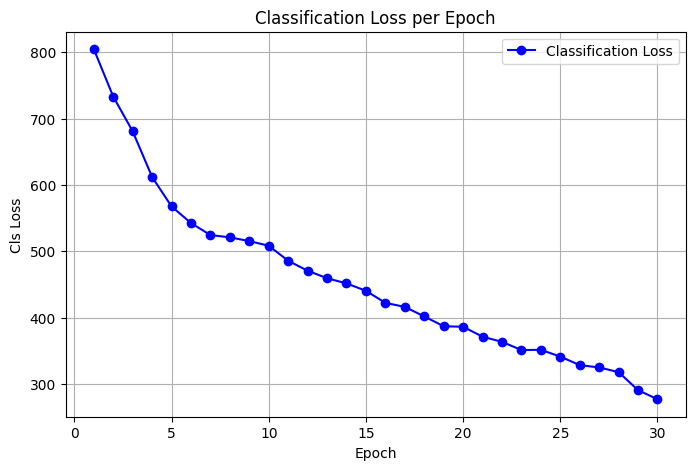

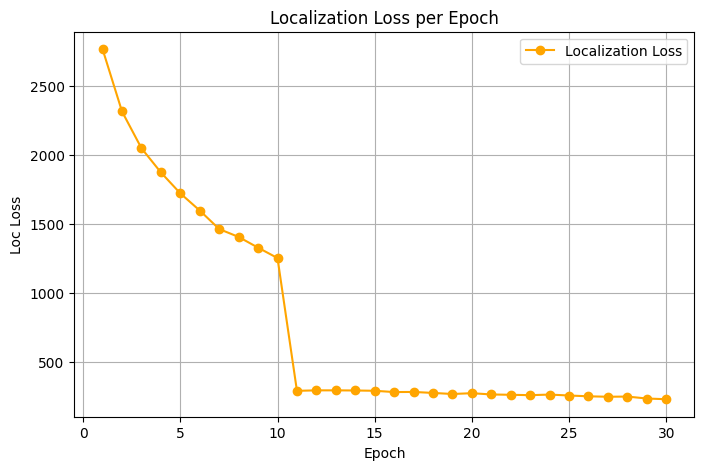

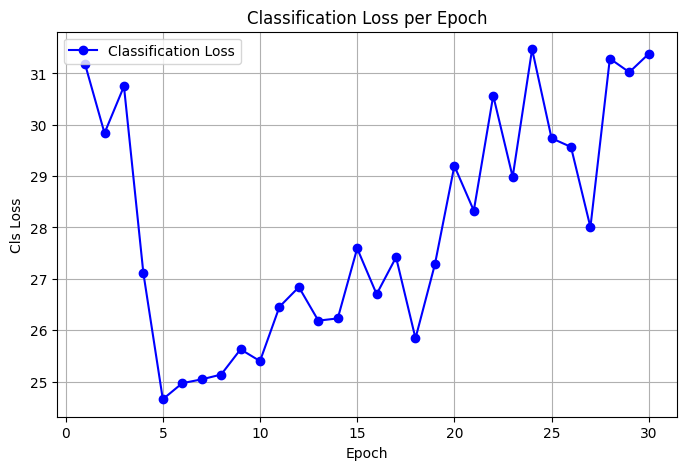

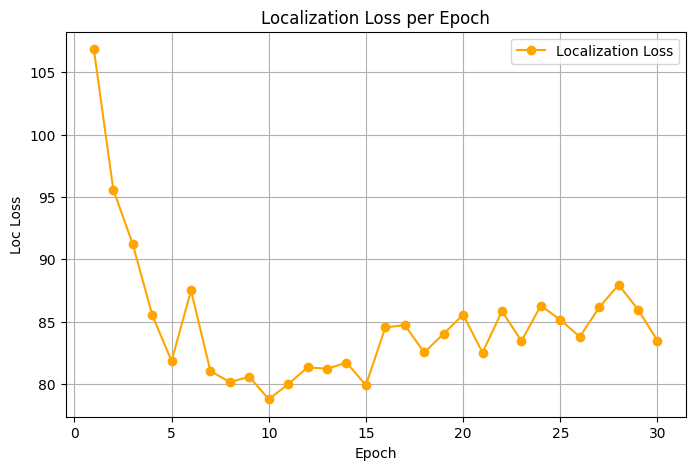

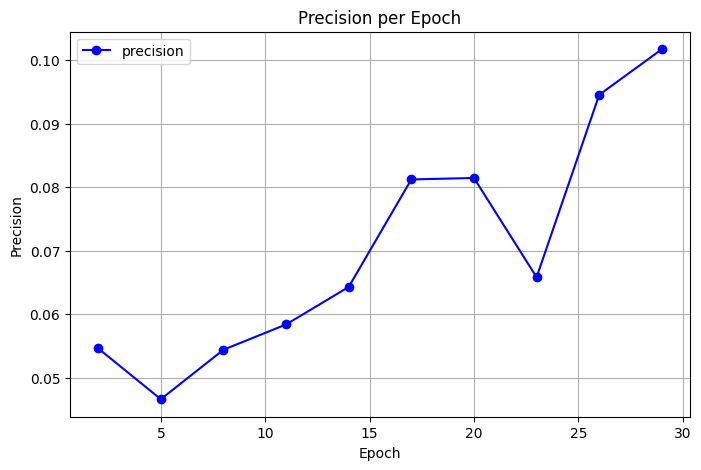

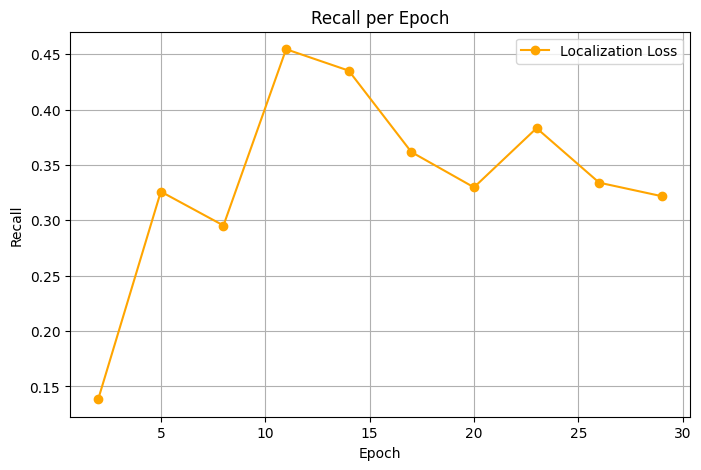

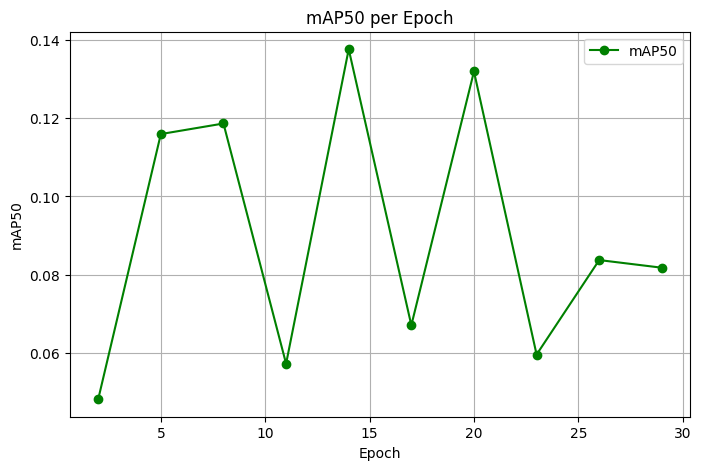

In [ ]:
plot_losses_from_csv("training_losses.csv")
plot_losses_from_csv("validation_losses.csv")
plot_mAP50_from_csv("average_precision.csv")


In [ ]:
# code for resuming training
last_epoch = 15 # epoch in which to resume training
checkpoint_path = f"/content/checkpoint_epoch_{last_epoch}.pth"
checkpoint = torch.load(checkpoint_path)

model = SSD(backbone, fpn, detection_heads)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)

# Example of newly outputted data

In [ ]:
# mAP50 and precision-recall graph
ap, precisions, recalls = compute_mAP50(model, val_DataLoader, anchors, device, nms_thresh=0.5, show_graph=True)
print(f"mAP50: {ap}")
print(f"Precision: {precisions}")
print(f"Recall: {recalls}")

In [ ]:
img_dir = "/content/drive/MyDrive/APS360_Project/Collected_Data/img/20250813_075446_jpg.rf.d8797900592f8ef1860476e91f74c49e.jpg"
json_dir = "/content/drive/MyDrive/APS360_Project/Collected_Data/json/20250813_075446_jpg.rf.d8797900592f8ef1860476e91f74c49e.json"

In [ ]:
import json
from PIL import Image
import torch
from torchvision.transforms.functional import to_tensor
from torchvision.transforms import Normalize

def evaluate_single_image(model, img_path, json_path, anchors, device, conf_thresh=0.7, nms_thresh=0.5, score_thresh=0.3):
    """
    Evaluate one image with GT annotation and visualize predictions.
    """
    # --- Load image ---
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = to_tensor(img_pil)  # [0,1] range
    # Apply same normalization as training
    normalize = Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
    img_tensor = normalize(img_tensor).unsqueeze(0).to(device)

    # --- Load JSON annotation ---
    with open(json_path, "r") as f:
        data = json.load(f)

    gt_boxes = []
    for ann in data.get("annotations", []):
        coords = ann["coordinates"]
        cx, cy, w, h = coords["x"], coords["y"], coords["width"], coords["height"]
        xmin = cx - w / 2
        ymin = cy - h / 2
        xmax = cx + w / 2
        ymax = cy + h / 2
        gt_boxes.append([xmin, ymin, xmax, ymax])
    gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32).to(device)

    # --- Inference ---
    model.eval()
    with torch.no_grad():
        pred_boxes, pred_scores = run_inference(
            model, img_tensor, anchors, device, conf_thresh, nms_thresh
        )

    # --- Visualize ---
    denorm_img = img_tensor[0].cpu()
    denorm_img = denormalize(denorm_img)  # Your existing helper
    img_vis = to_pil_image(denorm_img)
    draw_gt_and_preds(img_vis, gt_boxes.cpu(), pred_boxes, pred_scores, score_thresh)

    return img_vis


Score stats → min: 0.039, max: 0.812, mean: 0.332
final_boxes: torch.Size([1, 4]) → Num kept: 1


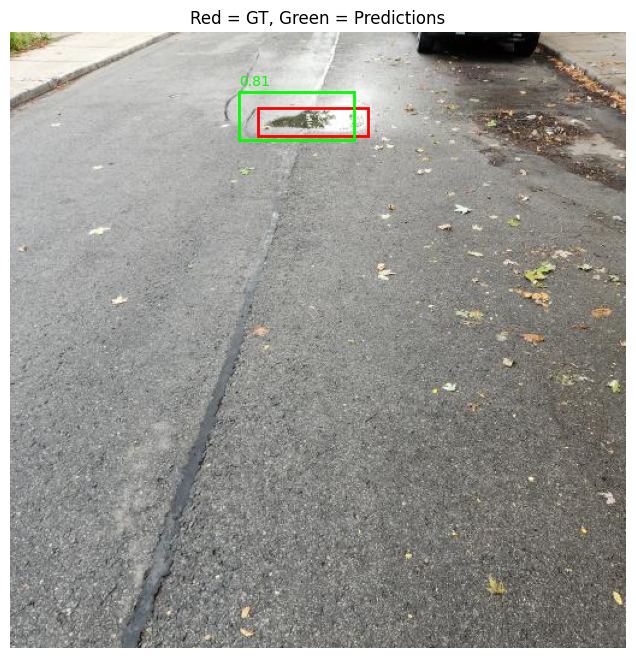

In [ ]:
img_vis = evaluate_single_image(model, img_dir, json_dir, anchors, device)
img_vis.show()